In [1]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class PCA:
    
    """
    Standardize the data by subtracting respective means of features
    """
    
    def standardize(self,data_input):
        mean = np.mean(data_input,axis = 0)
        return data_input - mean
    
    """
    Extract the eigen values from X-transpose-X
    X-transpose-X => Covariance matrix
    """
    
    def eigenvalueExtraction(self,data_input):
        std_data = self.standardize(data_input)
        cov_matrix = np.matmul(std_data.T, std_data)
        eigen_vals, eigen_vectors = np.linalg.eig(cov_matrix)
        return std_data,eigen_vals,eigen_vectors
    
    """
    Select k eigen vectors for dimensionality reduction
    """
    
    def dimensionReduction(self,eig_val,eig_vec,k):
        return eig_val[:k],eig_vec[:,:k]
    
    """
    Reconstruction step for the scaled input data (normalized)
    """
    
    def reconstruction(self,scaled_X,eig_vec):
        return np.matmul(scaled_X,eig_vec)

    """
    Master function for applying PCA on a feature vector/vectors
    """
    
    def apply_pca(self,data,k=1):
        A, eigen_vals, eigen_vectors = self.eigenvalueExtraction(data)
        eigen_vals_red , eigen_vectors_red = self.dimensionReduction(eigen_vals,eigen_vectors,k)
        red_output_matrix = self.reconstruction(A,eigen_vectors_red)
        return A,eigen_vals,eigen_vectors,red_output_matrix

In [3]:
# extract black pixels from the image

In [20]:
template = cv2.imread('./problem4-dataset1/tool27.png')

In [21]:
template = template[:,:,0]//3 + template[:,:,1]//3 + template[:,:,2]//3

In [22]:
template.shape

(115, 115)

In [23]:
template

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [24]:
np.unique(template)

array([  0, 255], dtype=uint8)

In [25]:
L = []
for i in range(template.shape[0]):
    for j in range(template.shape[1]):
        if(template[i][j]==0):
            L.append((i,j))

In [26]:
len(L)

713

In [27]:
# Converting to numpy array
np_arr = np.array(L)

In [28]:
np_arr

array([[19, 54],
       [19, 55],
       [19, 56],
       ...,
       [98, 56],
       [98, 57],
       [98, 64]])

In [29]:
np_arr.shape

(713, 2)

<h3>Apply PCA for just getting the eigen vector axis</h3>

In [30]:
pca = PCA()

In [31]:
def plot_line_along_vector(vector,image,image_size=(128, 128)):
    # Create an empty image with a white background
#     image = np.ones((image_size[0], image_size[1], 3))
    
    # Midpoint of the image
    midpoint = np.array([image_size[0] // 2, image_size[1] // 2])
    
    # Use a factor to ensure the line crosses the entire image (This will be large enough for this purpose)
    factor = 1000
    
    start_point = midpoint - factor * vector
    end_point = midpoint + factor * vector

    # Plot the line on the image
    plt.imshow(image)
    
    plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], 'k-',color='red')  # note the y,x order because of how plt.plot works
    
    plt.xlim(0, image_size[0])
    plt.ylim(image_size[1], 0)  # Set the y limit in reverse because of the way images are displayed in matplotlib
    
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


In [32]:
_,_,eigen_vectors,_=pca.apply_pca(np_arr)

In [33]:
eigen_vectors

array([[ 0.99505061, -0.09936945],
       [ 0.09936945,  0.99505061]])

/tmp/ipykernel_209090/2839372075.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], 'k-',color='red')  # note the y,x order because of how plt.plot works


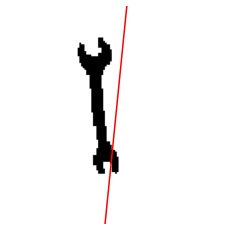

In [34]:
vector = eigen_vectors[0]
vector = vector / np.linalg.norm(vector)

rgb_im = cv2.cvtColor(template,cv2.COLOR_GRAY2BGR)

plot_line_along_vector(vector,rgb_im)

<h3>Rotate all images to the template</h3>

In [35]:
template_vector = eigen_vectors[0]

In [36]:
# check all images for the rotation

In [1]:
# angle calculation by chat gpt
def angle_between_vectors(a, b):
    # Compute the dot product
    dot_product = np.dot(a, b)
    
    # Compute the magnitudes of the vectors
    magnitude_a = np.linalg.norm(a)
    magnitude_b = np.linalg.norm(b)
    
    # Compute the cosine of the angle
    cosine_angle = dot_product / (magnitude_a * magnitude_b)
    
    # Ensure the value lies between -1 and 1 to avoid numerical errors
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    # Compute the angle and convert to degrees
    angle = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle)
    
    return angle_degrees

<h3>Algorithm</h3>

In [42]:
import os

root = './problem4-dataset1'
for num,image in enumerate(os.listdir(root)):
    img = cv2.imread(os.path.join(root,image))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    L = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j]==0):
                L.append((i,j))
    np_arr = np.array(L)
    pca = PCA()
    _,_,eigen_vectors,_=pca.apply_pca(np_arr)
    candidate_eig_vector= eigen_vectors[0]
    
    angle_deg = angle_between_vectors(candidate_eig_vector,template_vector)
    height, width = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 180 + angle_deg, 1.0)

    # Perform the rotation
    rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))
    
    cv2.imwrite(f'./problem4-dataset1-soln/{num}.png',rotated_image)

# Algorithm Flowchart

1. Load the template image.
2. Extract the coordinates of black pixels from the template image.
3. Perform PCA (Principal Component Analysis) on the coordinates to find the first eigen vector (reference line).
4. Load the input image.
5. Extract the coordinates of black pixels from the input image.
6. Perform PCA on the input image coordinates to obtain the corresponding eigen vector.
7. Calculate the angle between the reference vector and the input vector.
8. Rotate the input image by the calculated angle to align the vectors.
9. Save or use the aligned image.
10. Repeat steps 4 to 9 for all images in the KIMIA Dataset.

In [50]:
# showing the montage of images after rotation

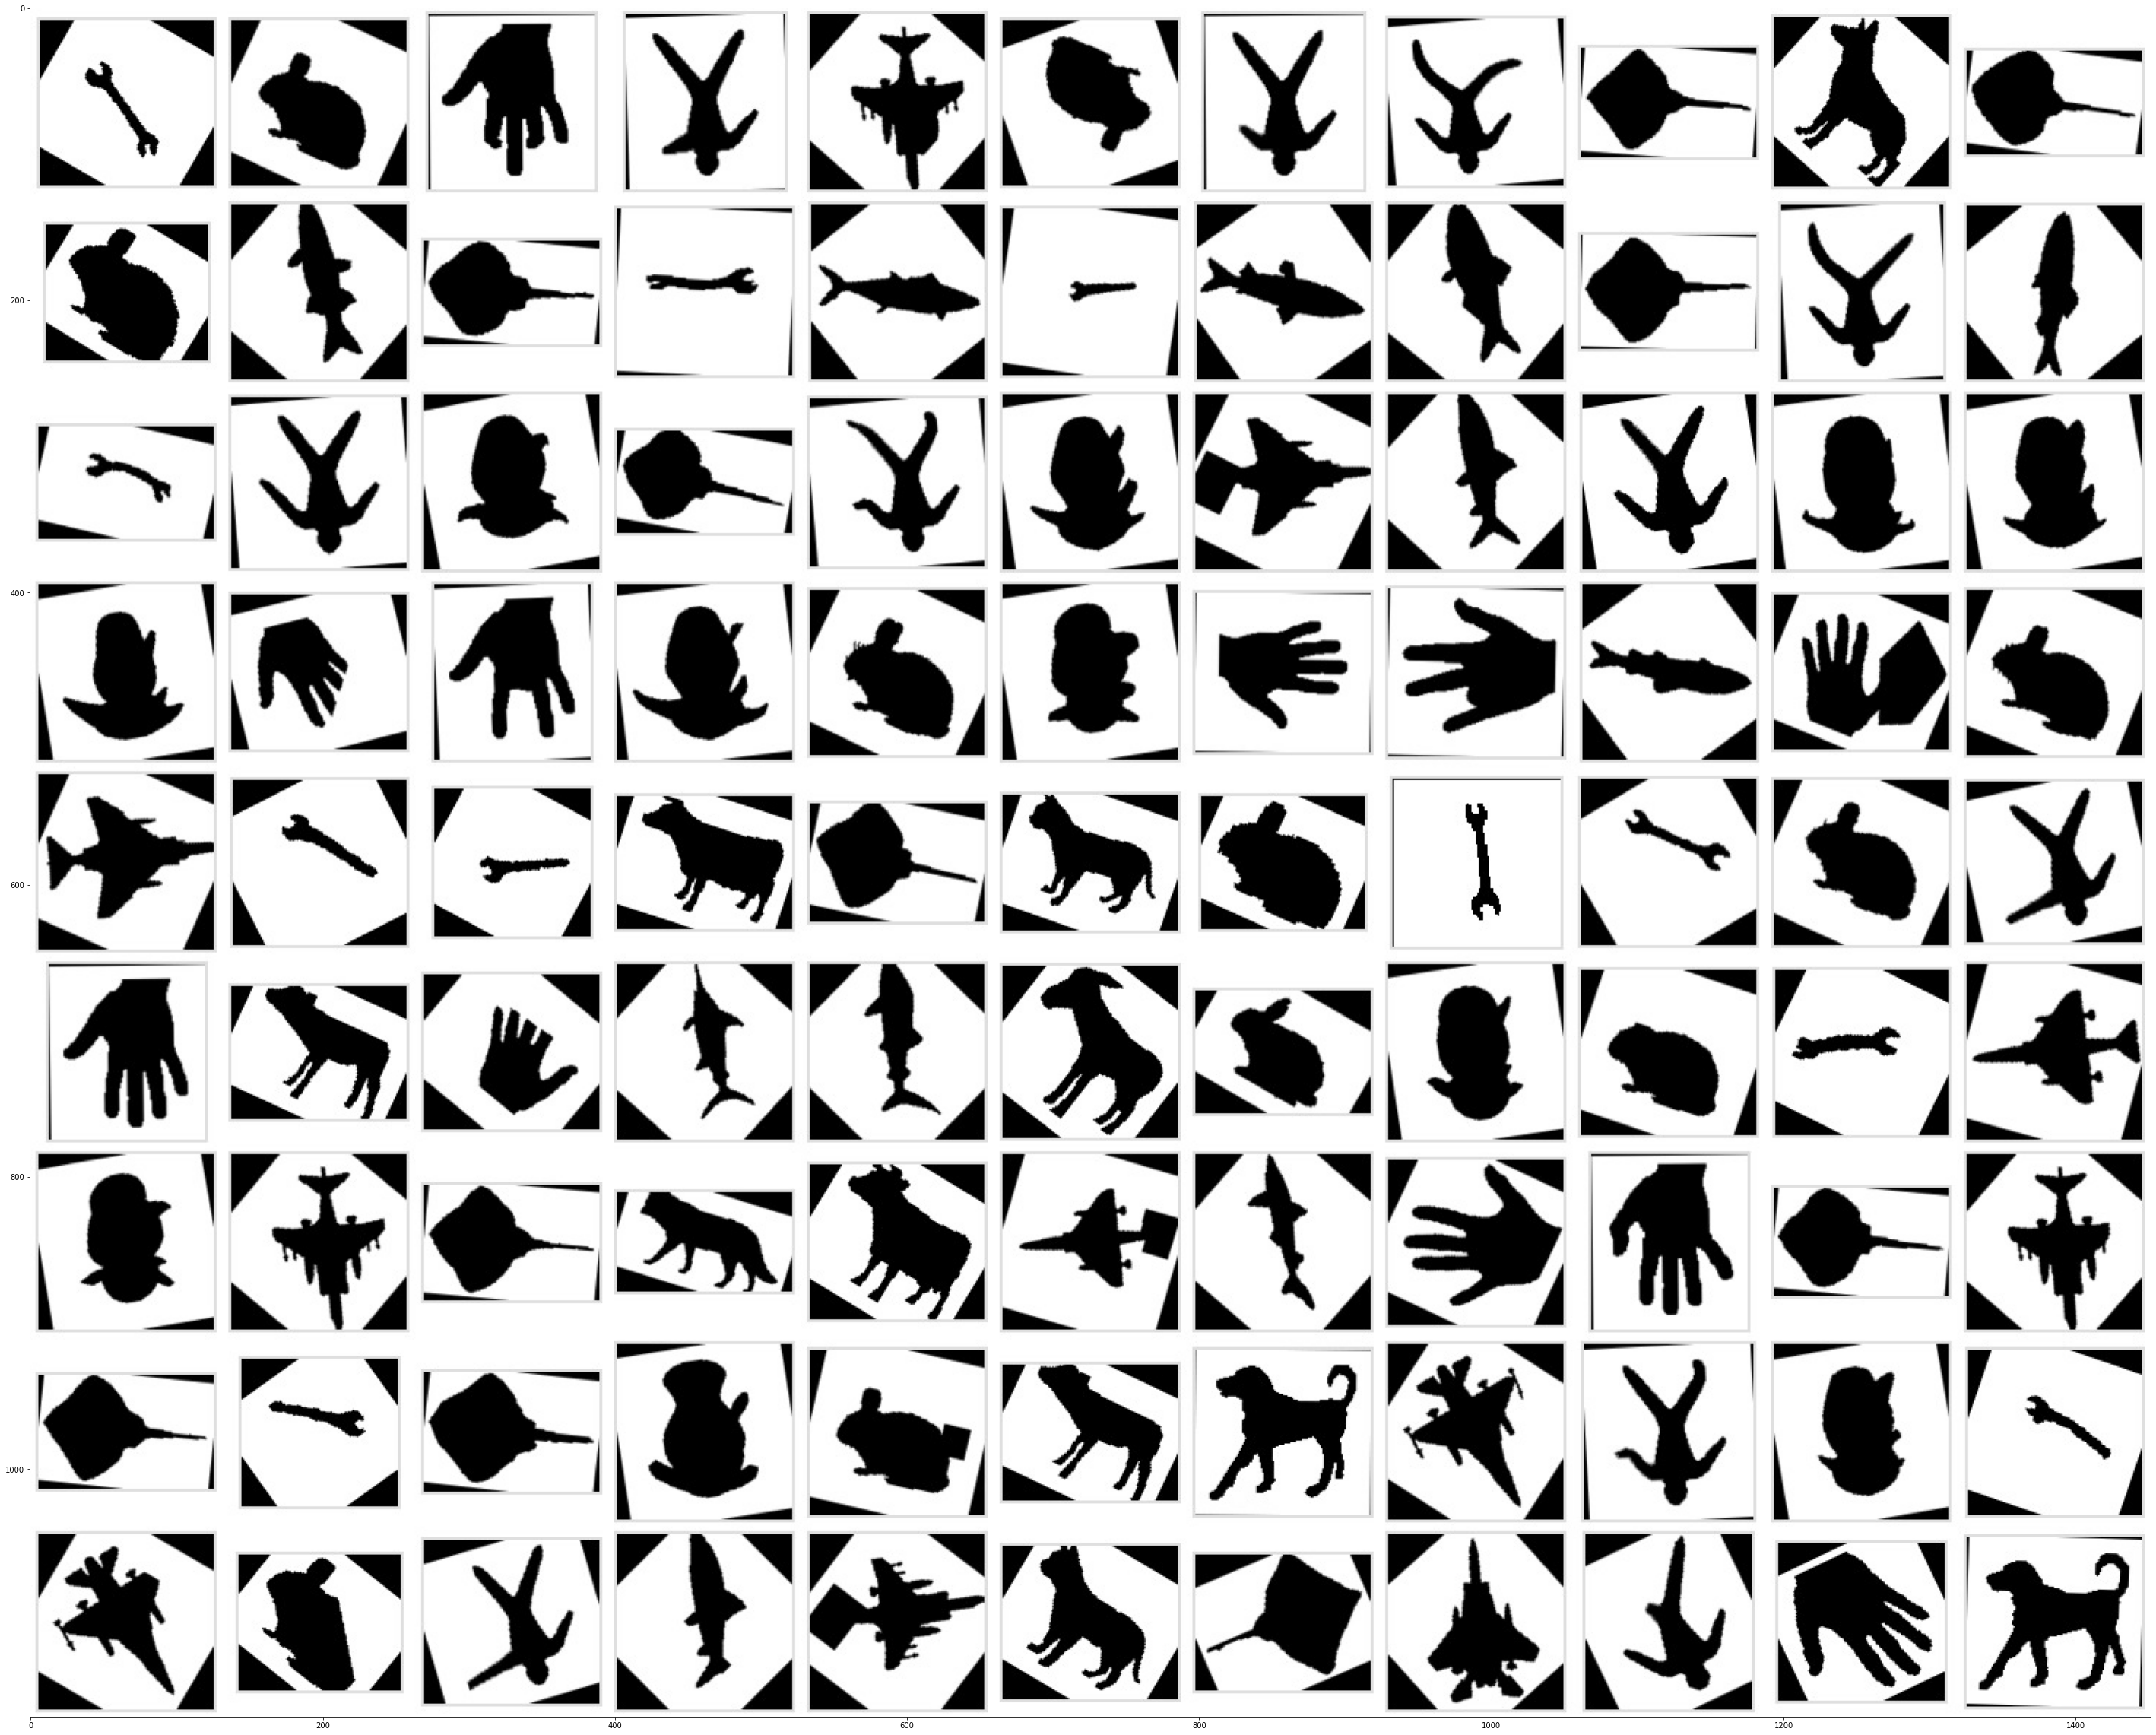

In [51]:
image_collection = cv2.imread('montage.jpg')

fig,axs = plt.subplots(1,1,figsize=(50,50))
axs.imshow(image_collection)
plt.show()